## Comparing Covid-19 cases with University population
This code loads data from various places regarding covid-19 cases and University information.  These data are defined
at the Middle Layer Super Output Are (MSOA) level

In [1]:

import pandas
import numpy as np
import requests
import os.path
import time
from uk_covid19 import Cov19API

In [2]:

# Calculate distances between lat/lon in miles.
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon / 2.0) ** 2

    dist = 2 * np.arcsin(np.sqrt(haver_formula))
    dist = 3958 * dist  # 6367 for distance in KM for miles use 3958
    return dist


def get_file(url):
    local_filename = url.split('/')[-1]
    r = requests.get(url)
    open(local_filename, 'wb').write(r.content)
    return

In [56]:
if not os.path.isfile('./MSOA_2011_EW_PWC_COORD_V2.CSV'):
    url = "https://github.com/ITSLeeds/pct/releases/download/0.2.5/MSOA_2011_EW_PWC_COORD_V2.CSV"
    get_file(url)

# Get Univeristy information.
if not os.path.isfile('./learning-providers-plus.csv'):
    url = "http://learning-provider.data.ac.uk/data/learning-providers-plus.csv"
    get_file(url)

# # Get the latest case data from gov.uk
# filename = './MSOAs_latest.csv'
# # if the file doesn't exist or it is more than 24 hours old
# if not os.path.isfile(filename) or \
#         (time.time() - os.path.getmtime(filename)) / (60 * 60) > 24:
#     url = "https://coronavirus.data.gov.uk/downloads/msoa_data/MSOAs_latest.csv"
#     get_file(url)

In [57]:
#
# all_nations = [
#     "areaType=region"
# ]
#
# cases_and_deaths = {
#     "date": "date",
#     "areaName": "areaName",
#     "areaCode": "areaCode",
#     "newCasesByPublishDate": "newCasesByPublishDate",
#     "newCasesBySpecimenDate": "newCasesBySpecimenDate",
#     "cumCasesByPublishDate": "cumCasesByPublishDate",
#     "newDeathsByDeathDate": "newDeathsByDeathDate",
#     "cumDeathsByDeathDate": "cumDeathsByDeathDate"
#    # "newTestsByPublishDate": "newTestsByPublishDate"
# }
#
# api = Cov19API(
#     filters=all_nations,
#     structure=cases_and_deaths
# )
#
# # api.get_csv(save_as="data.csv")
# #  df = pandas.read_csv('./data.csv')
# df = api.get_dataframe()

In [58]:
MSOA_centroids = pandas.read_csv('./MSOA_2011_EW_PWC_COORD_V2.CSV')
MSOA_pop = pandas.read_csv('./MSOA_pop.csv')
HE_centroids = pandas.read_csv('./learning-providers-plus.csv')
covidCases = pandas.read_csv('./MSOAs_latest.csv')

MSOA_student_pop = pandas.read_csv('./MSOA_student_pop.csv')

russell_group_rows = (HE_centroids['GROUPS'].str.contains('Russell_Group') == True)
million_plus_rows = (HE_centroids['GROUPS'].str.contains('Million') == True)
UA_rows = (HE_centroids['GROUPS'].str.contains('University_Alliance') == True)

unis_2_keep = np.ones((len(HE_centroids.index))) > 0
# unis_2_keep = russell_group_rows | million_plus_rows
# unis_2_keep =  russell_group_rows
HE_centroids = HE_centroids.loc[unis_2_keep, :]

HE_lon = HE_centroids['LONGITUDE']
HE_lat = HE_centroids['LATITUDE']

# Calculate distances. NOTE: This is a very slow way to do it
allDist = np.zeros((len(MSOA_centroids.index), len(HE_centroids.index)))

for index, row in MSOA_centroids.iterrows():
    this_MSOA_lon = row['LONGITUDE']
    this_MSOA_lat = row['LATITUDE']

    theseDist = haversine(this_MSOA_lon, this_MSOA_lat, HE_lon, HE_lat)
    allDist[index,] = theseDist

uni_distance = np.nanmin(allDist, axis=1)
rg_distance = np.nanmin(allDist[:, russell_group_rows], axis=1)
mp_distance = np.nanmin(allDist[:, million_plus_rows], axis=1)
closestUniIdx = np.nanargmin(allDist, axis=1)
uni_name = HE_centroids['PROVIDER_NAME'].iloc[closestUniIdx].values
MSOA_centroids.insert(1, "uni_distance", uni_distance)
MSOA_centroids.insert(1, "rg_distance", rg_distance)
MSOA_centroids.insert(1, "mp_disance", rg_distance)
MSOA_centroids.insert(1, "uni_name", uni_name)






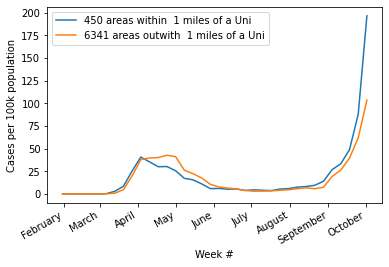

In [59]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime


# Distance in miles to separate areas
distThresh = 1
#*****



merged = pandas.merge(left=MSOA_centroids, right=covidCases, left_on='MSOA11CD', right_on='msoa11_cd')
merged = pandas.merge(left=merged, right=MSOA_pop, left_on='MSOA11CD', right_on='MSOA Code')
merged = pandas.merge(left=merged, right=MSOA_student_pop, left_on='MSOA11CD', right_on='MSOA Code')

merged = merged.replace(-99, 0)
merged = merged.sort_values('uni_distance')

merged['latest_7_days_per_100k'] = 1e5 * merged.filter(like='latest_7_days').div(merged['All Ages'], axis=0)
merged['Student Percentage'] = merged['Student Population'] / merged['All Ages']


close = merged.loc[merged['uni_distance'] < distThresh, :]
far = merged.loc[merged['uni_distance'] >= distThresh, :]
numberClose = len(close)
numberFar = len(far)
# nNear = 400;
# close = merged.iloc[1:nNear,:]
# far = merged.iloc[(nNear+1):,:]

closeTotalPop = np.sum(close['All Ages'])
farTotalPop = np.sum(far['All Ages'])
# closeCasePer100 = 1e5*np.nansum(close.filter(like='wk_'), axis=0)/closeTotalPop
# farCasePer100 = 1e5*np.nansum(far.filter(like='wk_'), axis=0)/farTotalPop

closeCasePer100 = np.nanmean(1e5 * close.filter(like='wk_').div(close['All Ages'], axis=0), axis=0)
farCasePer100 = np.nanmean(1e5 * far.filter(like='wk_').div(far['All Ages'], axis=0), axis=0)

first = datetime.datetime.fromisocalendar(2020, 5, 5)
last  = datetime.datetime.fromisocalendar(2020, len(closeCasePer100)-1+5, 6)
date_range = mdates.drange(first,last,datetime.timedelta(days=7))


plt.plot(date_range,closeCasePer100)
plt.plot(date_range,farCasePer100)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday=1))
plt.ylabel('Cases per 100k population')
plt.xlabel('Week #')
plt.gcf().autofmt_xdate()

plt.legend([str(numberClose) + ' areas within  ' + str(distThresh ) + ' miles of a Uni',
            str(numberFar) + ' areas outwith  ' + str(distThresh ) + ' miles of a Uni'])

plt.show()

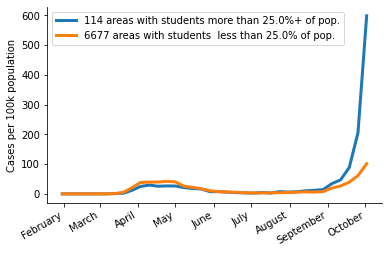

In [60]:

###

thresh = .25

####

close = merged.loc[merged['Student Percentage'] >= thresh, :]
far = merged.loc[merged['Student Percentage'] < thresh, :]

# nNear = 400;
# close = merged.iloc[1:nNear,:]
# far = merged.iloc[(nNear+1):,:]

closeTotalPop = np.sum(close['All Ages'])
farTotalPop = np.sum(far['All Ages'])
# closeCasePer100 = 1e5*np.nansum(close.filter(like='wk_'), axis=0)/closeTotalPop
# farCasePer100 = 1e5*np.nansum(far.filter(like='wk_'), axis=0)/farTotalPop

closeCasePer100 = np.nanmean(1e5 * close.filter(like='wk_').div(close['All Ages'], axis=0), axis=0)
farCasePer100 = np.nanmean(1e5 * far.filter(like='wk_').div(far['All Ages'], axis=0), axis=0)

numberClose = len(close)
numberFar = len(far)
ax = plt.subplot(111)

ax.plot(date_range,closeCasePer100, linewidth=3)
ax.plot(date_range,farCasePer100, linewidth=3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=1))

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.ylabel('Cases per 100k population')
plt.legend([str(numberClose) + ' areas with students more than ' + str(thresh * 100) + '%+ of pop.',
            str(numberFar) + ' areas with students  less than ' + str(thresh * 100) + '% of pop.'])
# plt.title('Cases Per 100k in Univ')
plt.gcf().autofmt_xdate()
plt.show()

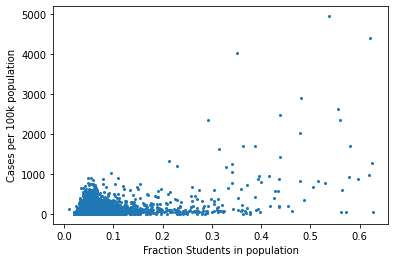

In [61]:

merged = merged.sort_values('latest_7_days', ascending=False)

targetWeek = 'latest_7_days'
tmp = merged

# plt.scatter(tmp['Student Percentage'],tmp[targetWeek],s=4)
plt.scatter(tmp['Student Percentage'], 1e5 * tmp[targetWeek].div(tmp['All Ages'], axis=0), s=4)

plt.ylabel('Cases per 100k population')
plt.xlabel('Fraction Students in population')
plt.show()

In [62]:
from IPython.display import display, HTML



top30 = merged.head(30).copy()

top30['Student Percentage']=top30['Student Percentage'].mul(100)

# top30 = top30[
#     ['LA name (2020 boundaries)', 'msoa11_hclnm', 'latest_7_days', 'latest_7_days_per_100k', 'uni_distance', 'Student Population',
#      'Student Percentage', 'uni_name']]
top30 = top30[
     ['LA name (2020 boundaries)', 'msoa11_hclnm', 'latest_7_days', 'latest_7_days_per_100k','Student Percentage', 'uni_name',
      'uni_distance']]

di = {'msoa11_hclnm': 'Neighbourhood',
      'LA name (2020 boundaries)': 'Local Authority',
      'latest_7_days': 'Number of Cases',      
      'latest_7_days_per_100k': 'Cases per 100k pop',
      'uni_distance': 'Miles to Univeristy',
      'uni_name': 'Nearest University'
     }

top30.rename(di,axis=1,inplace=True)

pandas.set_option('precision',2)

display(HTML(top30.to_html(formatters={'Cases per 100k pop': '{:,.0f}'.format, 'Student Percentage': '{:,.0f}%'.format},index=False)))

Local Authority,Neighbourhood,Number of Cases,Cases per 100k pop,Student Percentage,Nearest University,Miles to Univeristy
Nottingham,"University Park, Lenton Abbey & Jubilee Campus",546,"4,955",54%,"UNIVERSITY OF NOTTINGHAM, THE",0.73
Manchester,Fallowfield Central,528,"4,419",62%,THE UNIVERSITY OF MANCHESTER,1.85
Sheffield,Endcliffe & Ranmoor,408,"4,044",35%,UNIVERSITY OF SHEFFIELD,1.53
Leeds,Hyde Park Corner & Woodhouse Cliff,364,"2,620",56%,UNIVERSITY OF LEEDS,0.76
Newcastle upon Tyne,Shieldfield & Heaton Park,332,"1,623",31%,NORTHUMBRIA UNIVERSITY NEWCASTLE,0.40
Manchester,Rusholme East,322,"2,486",44%,THE UNIVERSITY OF MANCHESTER,1.29
Liverpool,Central & Islington,298,"1,701",39%,UNIVERSITY OF LIVERPOOL,0.06
Manchester,Ladybarn,281,"2,908",48%,THE UNIVERSITY OF MANCHESTER,2.28
Exeter,Pennsylvania & University,274,"2,356",29%,UNIVERSITY OF EXETER,0.45
Leeds,University & Little Woodhouse,270,"2,354",56%,UNIVERSITY OF LEEDS,0.53
